# Detection and Alarm Classification

In this notebook, we'll expand on the whistle detector and include alarm classification. Thus, it follows a similar structure.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
import pathlib
from fastai2.vision.all import *
import tqdm
from IPython.display import Audio
from itertools import count

import scipy.signal
from scipy import interpolate
import soundfile as sf
import librosa
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.neighbors import KNeighborsClassifier

import umap
import umap.plot

from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE
output_notebook(resources=INLINE)

Loading BokehJS ...

In [2]:
DATA = '../DataTableV1.csv'

SR = 72000
WINDOW_S = 1.0
NFFT = 1024
HOP_LENGTH = None
WINDOW = scipy.signal.hanning
DB_TH = 1e-4
RES = 64
FMAX = 20000
FMIN = 5000
MAX = 1
MIN = 0
POWER_FACTOR = 100000
WINDOW_WIDTH = int(WINDOW_S*SR)

LATENT_DIM = 256
DIMS = (RES,RES,1)

MEMBERS = 1
EPOCHS_REPEAT = 10
EPOCHS = 10
BATCH_SIZE = 16
VERBOSE = 1

NEIGHBORS = 10

In [3]:
data_df = pd.read_csv(DATA)
detection_df = data_df[data_df.Detection!=0]
no_detection_df = data_df[data_df.Detection==0]

In [6]:
alarm_df = detection_df[detection_df.Alarm_Label=='Prestranding']
no_alarm_df = detection_df[detection_df.Alarm_Label=='Nonstranding']

In [10]:
def load_detection(data_table, row_index=0, window_length=None):
    start = data_table.Starts_s.iloc[row_index]
    end = data_table.Ends_s.iloc[row_index]
    
    if window_length is None:
        window_length = end - start
    
    wf, _ = librosa.load('../'+data_table.Wav_Path.iloc[row_index], 
                         sr=None,
                         offset=start,
                         duration=window_length) 
    return wf

In [11]:
def load_no_detection(data_table, row_index=0, start=0, window_length=WINDOW_S):
    
    wf, _ = librosa.load('../'+data_table.Wav_Path.iloc[row_index], 
                         sr=None,
                         offset=start,
                         duration=window_length)      
    return wf

Regarding notation, we'll use a '1' to denote a whistle, a '0' to represent background, and 'a' and 'n' to signify alarm and no alarm, respectively. A 'D' will correspond to the detection task and an 'A' will mean the alarm task.

In [12]:
X1_audio = np.zeros((len(detection_df), int(SR*WINDOW_S)), dtype='float32')
Y1 = np.ones(X1_audio.shape[0], dtype='int32')
for i in tqdm.tqdm(range(len(detection_df))):
    X1_audio[i] = load_detection(detection_df, row_index=i, window_length=WINDOW_S)

100%|██████████| 1239/1239 [00:00<00:00, 1736.60it/s]


In [13]:
np.random.seed(0)
neg_indices_wav = np.random.randint(low=0, high=len(no_detection_df), size=X1_audio.shape[0])
neg_starts = np.random.uniform(low=50, high=850, size=X1_audio.shape[0])
X0_audio = np.zeros_like(X1_audio, dtype='float32')
Y0 = np.zeros(X0_audio.shape[0], dtype='int32')
for i in tqdm.tqdm(range(X1_audio.shape[0])):
    wav_idx = neg_indices_wav[i]
    start = neg_starts[i]
    try:
        X0_audio[i] = load_no_detection(no_detection_df, row_index=wav_idx, start=start)
    except:
        print(wav_idx, start)
        break

100%|██████████| 1239/1239 [00:00<00:00, 2472.84it/s]


In [14]:
Xa_audio = np.zeros((len(alarm_df), int(SR*WINDOW_S)), dtype='float32')
Ya = np.ones(Xa_audio.shape[0], dtype='int32')
for i in tqdm.tqdm(range(len(alarm_df))):
    Xa_audio[i] = load_detection(alarm_df, row_index=i, window_length=WINDOW_S)

100%|██████████| 1079/1079 [00:00<00:00, 1740.43it/s]


In [15]:
Xn_audio = np.zeros((len(no_alarm_df), int(SR*WINDOW_S)), dtype='float32')
Yn = np.ones(Xn_audio.shape[0], dtype='int32')
for i in tqdm.tqdm(range(len(no_alarm_df))):
    Xn_audio[i] = load_detection(no_alarm_df, row_index=i, window_length=WINDOW_S)

100%|██████████| 160/160 [00:00<00:00, 1703.05it/s]


For this first pass, we'll simply balance the datasets by truncating the alarm whistle array.

In [18]:
indices = np.random.randint(low=0, high=Xa_audio.shape[0], size=Xn_audio.shape[0])
Xa_audio = Xa_audio[indices]
Ya = Ya[indices]

Gathering our results we have:

In [20]:
X1_audio.shape, Y1.shape, X0_audio.shape, Y0.shape, Xa_audio.shape, Ya.shape, Xn_audio.shape, Yn.shape

((1239, 72000),
 (1239,),
 (1239, 72000),
 (1239,),
 (160, 72000),
 (160,),
 (160, 72000),
 (160,))

Concatenating these arrays yields:

In [21]:
X_D, Y_D = np.vstack([X0_audio, X1_audio]), np.hstack([Y0, Y1])
X_A, Y_A = np.vstack([Xn_audio, Xa_audio]), np.hstack([Yn, Ya])

X_D_train, X_D_test, Y_D_train, Y_D_test = train_test_split(X_D, Y_D, test_size=0.2, random_state=42)
X_D_train.shape, Y_D_train.shape, X_D_test.shape, Y_D_test.shape

((1982, 72000), (1982,), (496, 72000), (496,))

In [22]:
X_A_train, X_A_test, Y_A_train, Y_A_test = train_test_split(X_A, Y_A, test_size=0.2, random_state=42)
X_A_train.shape, Y_A_train.shape, X_A_test.shape, Y_A_test.shape

((256, 72000), (256,), (64, 72000), (64,))

# Building the Models

In [ ]:
X_D_train, X_D_test, Y_D_train, Y_D_test = train_test_split(X_D, Y_D, test_size=0.2, random_state=42)
X_D_train.shape, Y_D_train.shape, X_D_test.shape, Y_D_test.shape

In [23]:
class SpecGram(tf.keras.layers.Layer):    
    def __init__(self, 
                 name='spectrogram',
                 sr=SR, nfft=NFFT, 
                 hop_length=HOP_LENGTH, 
                 db_th=DB_TH, 
                 win=WINDOW, 
                 fmin=FMIN, 
                 fmax=FMAX, 
                 win_width=WINDOW_WIDTH,
                 **kwargs):
        super(SpecGram, self).__init__()
        self.sr = sr
        self.nfft = nfft
        
        if hop_length is None:
            self.hop_length = nfft // 16
        else:
            self.hop_length = hop_length
        
        self.db_th = db_th
        self.win = win
        
        if fmin is None:
            fmin = lambda f: np.min(f)
        else:
            self.fmin = fmin
        if fmax is None:
            self.fmax = lambda f: np.max(f)
        else:
            self.fmax = fmax
        if (fmin is not None) and (fmax is not None):
            self.f_conditions = lambda f: (f > fmin) & (f < fmax)
        else:
            self.f_conditions = lambda f: [True for _ in f]
            
        self.in_size = win_width
        self.out_size = self.compute_out_size()

    def call(self, x):
        return self.spectrogram_representation(x)

    @tf.function
    def spectrogram_representation(self, x):

        def construct_spectrogram(signal, 
                                  sr=self.sr, 
                                  nfft=self.nfft, 
                                  hoplength=self.hop_length, 
                                  win=self.win,
                                  db_th=self.db_th):
            _, _, spec = librosa.reassigned_spectrogram(y=signal, sr=sr, n_fft=nfft, hop_length=hoplength, window=win)
            spec_db = librosa.power_to_db(spec, amin=db_th)
            #f_bins = librosa.core.fft_frequencies(sr=sr, n_fft=nfft)
            #t_bins = np.linspace(0, len(signal)/sr, spec[0].shape[0])
            return spec_db

        def generate_representation(waveforms,
                                    sr=self.sr, 
                                    nfft=self.nfft, 
                                    hoplength=self.hop_length, 
                                    win=self.win,
                                    db_th=self.db_th):
            batch_size = waveforms.shape[0]
            reps = np.zeros((batch_size, self.out_size[0], self.out_size[1]))
            f_bins = librosa.core.fft_frequencies(sr=self.sr, n_fft=self.nfft)
            f_conditions = self.f_conditions(f_bins)
            for n in range(batch_size):
                Sxx = construct_spectrogram(waveforms[n,:], sr=sr, nfft=nfft, win=win, db_th=db_th)
                Sxx = Sxx[f_conditions]
                reps[n, :, :] = Sxx
            return reps.astype('float32')

        @tf.function(input_signature=[tf.TensorSpec(None, tf.float32)])
        def tf_rep(input_):
            y = tf.numpy_function(generate_representation, [input_], tf.float32)
            return y

        x = tf.cast(x, tf.float32)
        result = (tf_rep(x))
        return tf.keras.backend.reshape(result, (-1, self.out_size[0], self.out_size[1]))

    def compute_out_size(self):
        out_t = (self.in_size // self.hop_length) + 1
        f_bins = librosa.core.fft_frequencies(sr=self.sr, n_fft=self.nfft)
        f_conditions = self.f_conditions(f_bins)
        f_bins = f_bins[f_conditions]
        out_f = len(f_bins)
        return (out_f, out_t)
    
    def get_tf_bins(self):
        t_bins = np.linspace(0, self.in_size / self.sr, self.out_size[1])
        f_bins = librosa.core.fft_frequencies(sr=self.sr, n_fft=self.nfft)
        f_conditions = self.f_conditions(f_bins)
        f_bins = f_bins[f_conditions]
        return t_bins, f_bins

    def vis_rep(self, X_examples, Y_examples):
        N_examples = X_examples.shape[0]

        def is_sqrt(x):
            sq = np.sqrt(x)
            return (sq - np.floor(sq))==0

        if ~is_sqrt(N_examples):
            raise ValueError('Choose a perfect square number of examples')
        else:
            plot_dim = int(np.sqrt(N_examples))
    
        t,f = self.get_tf_bins()
        
        reps = self.spectrogram_representation(X_examples)
        fig, axes = plt.subplots(plot_dim, plot_dim, figsize=(15, 10))
        axs = axes.flatten()
        for n in range(N_examples):
            axs[n].pcolormesh(t, f, reps[n, :, :], cmap='magma')
            axs[n].invert_yaxis()
            axs[n].set_xticks([])
            axs[n].set_yticks([])
            axs[n].set_title(f'Class {Y_examples[n]}')

In [24]:
class MinMaxScaler(tf.keras.layers.Layer):
    def __init__(self, name='min_max_scaler', **kwargs):
        super(MinMaxScaler, self).__init__(name=name, **kwargs)

    def call(self, input_):
        return self.min_max_scaler(input_)

    @tf.function
    def min_max_scaler(self, x):
        batch, height, width = x.shape
        x = tf.cast(x, tf.float32)

        _min = tf.math.reduce_min(x, axis=2, keepdims=True, name=None)
        _min = tf.math.reduce_min(_min, axis=1, keepdims=True, name=None)

        _max = tf.math.reduce_max(x, axis=2, keepdims=True, name=None)
        _max = tf.math.reduce_max(_max, axis=1, keepdims=True, name=None)

        x_norm = (MAX - MIN) * (x - _min) / (_max - _min) + MIN
        return x_norm

    def get_config(self):
        config = super(MinMaxScaler, self).get_config()
        return config

In [25]:
class PowerNormalizer(tf.keras.layers.Layer):
    def __init__(self, name='normalizer_scaler', **kwargs):
        super(PowerNormalizer, self).__init__(name=name, **kwargs)

    def call(self, input_):
        return self.normalizer(input_)

    @tf.function
    def normalizer(self, x):
        batch, height, width = x.shape
        x = tf.cast(x, tf.float32)
        _sum = tf.math.reduce_sum(x, axis=2, keepdims=True)
        _sum = tf.math.reduce_sum(_sum, axis=1, keepdims=True)
        x_norm = tf.math.divide(x, _sum)
        x_norm = POWER_FACTOR * x_norm
        return x_norm

    def get_config(self):
        config = super(PowerNormalizer, self).get_config()
        return config

Let's build the spectrograms!

In [36]:
class SpecBuilder(tf.keras.Model):
    def __init__(self):
        super(SpecBuilder, self).__init__()
        self.builder = self.build_spec_model()

    def build_spec_model(self):
        spec_inputs = tf.keras.Input(shape=(WINDOW_WIDTH,))
        x = SpecGram()(spec_inputs)
        x = MinMaxScaler()(x)
        x = PowerNormalizer()(x)
        outputs = tf.keras.layers.Reshape((SpecGram().out_size[0], SpecGram().out_size[1], 1), 
                                      input_shape=SpecGram().out_size)(x)

        spec_model = tf.keras.Model(spec_inputs, outputs, name='spec_builder')
        return spec_model

    def call(self, x):
        return self.builder(x)
spec_builder = SpecBuilder().builder
spec_builder.summary()

Model: "spec_builder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 72000)]           0         
_________________________________________________________________
spec_gram_5 (SpecGram)       (None, 213, 1126)         0         
_________________________________________________________________
min_max_scaler (MinMaxScaler (None, 213, 1126)         0         
_________________________________________________________________
normalizer_scaler (PowerNorm (None, 213, 1126)         0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 213, 1126, 1)      0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [37]:
X_specs_D_train = np.zeros((X_D_train.shape[0], 213, 1126, 1), dtype='float32')
X_specs_D_test = np.zeros((X_D_test.shape[0], 213, 1126, 1), dtype='float32')

X_specs_A_train = np.zeros((X_A_train.shape[0], 213, 1126, 1), dtype='float32')
X_specs_A_test = np.zeros((X_A_test.shape[0], 213, 1126, 1), dtype='float32')

for i in tqdm.tqdm(range(X_D_train.shape[0])):
    X_specs_D_train[i] = spec_builder(np.expand_dims(X_D_train[i], axis=0)).numpy()
    
for i in tqdm.tqdm(range(X_D_test.shape[0])):
    X_specs_D_test[i] = spec_builder(np.expand_dims(X_D_test[i], axis=0)).numpy()
    
for i in tqdm.tqdm(range(X_A_train.shape[0])):
    X_specs_A_train[i] = spec_builder(np.expand_dims(X_A_train[i], axis=0)).numpy()
    
for i in tqdm.tqdm(range(X_A_test.shape[0])):
    X_specs_A_test[i] = spec_builder(np.expand_dims(X_A_test[i], axis=0)).numpy()

100%|██████████| 64/64 [00:04<00:00, 12.88it/s]


In [50]:
def build_detection_classifier():
    inputs = tf.keras.Input(shape=(213,1126,1))
    
    x = tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(3, 3),
                               activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(3, 3), 
                               activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(3, 3), 
                               activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    classifier = tf.keras.Model(inputs=inputs, outputs=outputs, name='baseline_classifier')
    return classifier

detection_model = build_detection_classifier()
detection_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                       metrics=['accuracy'])
detection_model.summary()

Model: "baseline_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 213, 1126, 1)]    0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 211, 1124, 32)     320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 105, 562, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 103, 560, 64)      18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 51, 280, 64)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 49, 278, 64)       36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 139, 64

In [51]:
detection_model.fit(X_specs_D_train, Y_D_train,
                     batch_size=BATCH_SIZE,
                     epochs=25,
                     verbose=1)

Epoch 1/25
124/124 [==============================] - 24s 192ms/step - loss: 0.7785 - accuracy: 0.4990
Epoch 2/25
124/124 [==============================] - 24s 190ms/step - loss: 0.6934 - accuracy: 0.5227
Epoch 3/25
124/124 [==============================] - 24s 190ms/step - loss: 0.6959 - accuracy: 0.5318
Epoch 4/25
124/124 [==============================] - 24s 191ms/step - loss: 0.6532 - accuracy: 0.6357
Epoch 5/25
124/124 [==============================] - 24s 190ms/step - loss: 0.4488 - accuracy: 0.8249
Epoch 6/25
124/124 [==============================] - 24s 191ms/step - loss: 0.3261 - accuracy: 0.8774
Epoch 7/25
124/124 [==============================] - 24s 191ms/step - loss: 0.2431 - accuracy: 0.9162
Epoch 8/25
124/124 [==============================] - 24s 191ms/step - loss: 0.2107 - accuracy: 0.9339
Epoch 9/25
124/124 [==============================] - 24s 191ms/step - loss: 0.1615 - accuracy: 0.9495
Epoch 10/25
124/124 [==============================] - 24s 191ms/step - l

In [52]:
def build_alarm_classifier():
    inputs = tf.keras.Input(shape=(213,1126,1))
    
    x = tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(3, 3),
                               activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(3, 3), 
                               activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(3, 3), 
                               activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    classifier = tf.keras.Model(inputs=inputs, outputs=outputs, name='alarm_classifier')
    return classifier

alarm_model = build_alarm_classifier()
alarm_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                       metrics=['accuracy'])
alarm_model.summary()

Model: "alarm_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 213, 1126, 1)]    0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 211, 1124, 32)     320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 105, 562, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 103, 560, 64)      18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 51, 280, 64)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 49, 278, 64)       36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 24, 139, 64)  

In [53]:
alarm_model.fit(X_specs_A_train, Y_A_train,
                 batch_size=BATCH_SIZE,
                 epochs=10,
                 verbose=1)

Epoch 1/10
16/16 [==============================] - 3s 198ms/step - loss: 0.0502 - accuracy: 0.9531
Epoch 2/10
16/16 [==============================] - 3s 192ms/step - loss: 4.6566e-10 - accuracy: 1.0000
Epoch 3/10
16/16 [==============================] - 3s 192ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/10
16/16 [==============================] - 3s 192ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
16/16 [==============================] - 3s 193ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
16/16 [==============================] - 3s 193ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
16/16 [==============================] - 3s 193ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
16/16 [==============================] - 3s 192ms/step - loss: 7.9162e-09 - accuracy: 1.0000
Epoch 9/10
16/16 [==============================] - 3s 192ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
16/16 [==============================] - 3s 193ms/step -

In [54]:
alarm_model.evaluate(X_specs_A_test, Y_A_test)

2/2 [==============================] - 0s 148ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

# Visualizations

In [55]:
trained_detector = detection_model
trained_alarm = alarm_model

In [130]:
import cv2
def vis_cam(inpt, img, class_label, model, layer_name):
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(inpt)
        loss = predictions[:, class_label]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.zeros(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (img.shape[0], img.shape[0]))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    output_cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    #output_cam = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)
    return output_cam

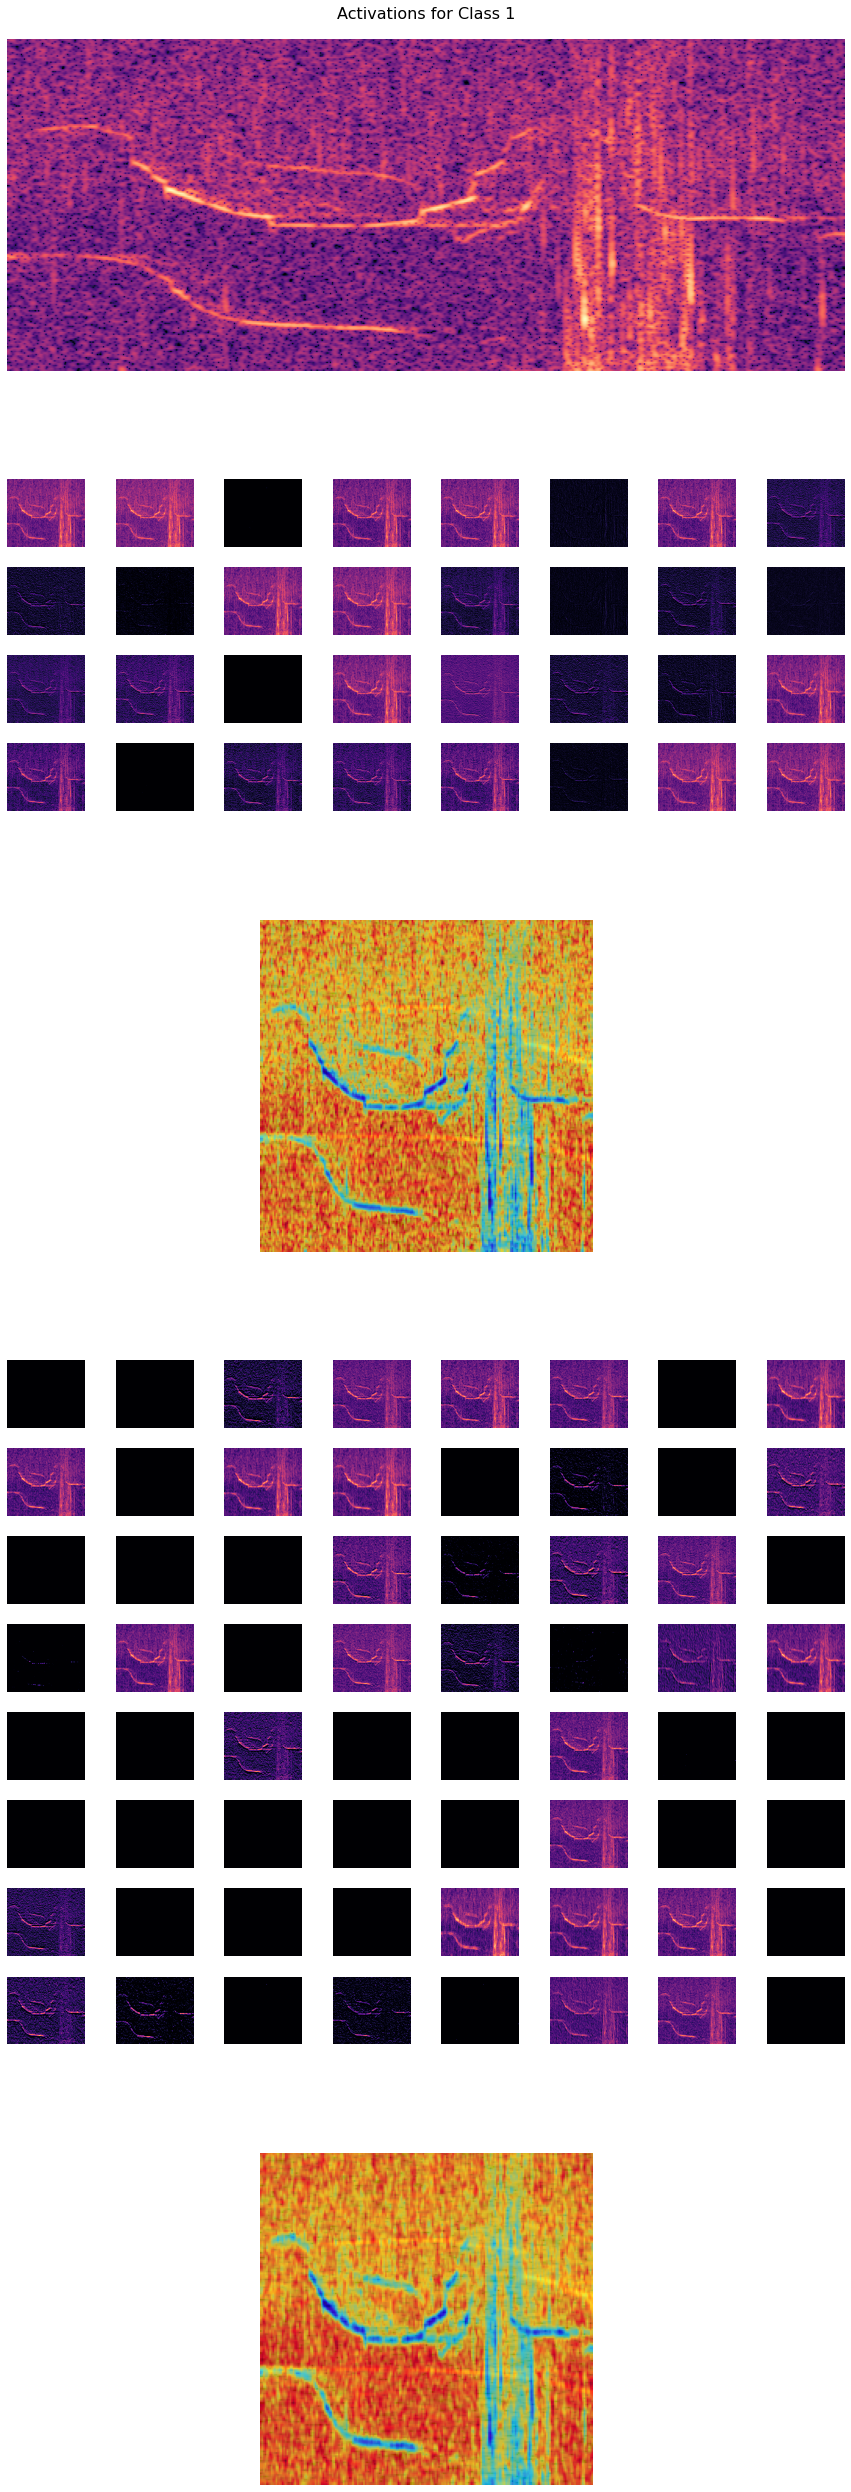

In [133]:
def vis_activations(X_data, Y_data, index, model):
    X_inpt = np.expand_dims(X_data[index], axis=0)
    Y_inpt = Y_data[index]
    
    spec = np.squeeze(X_inpt)
    
    conv_layers = []
    for layer in model.layers:
        if 'conv' not in layer.name:
            continue
        conv_layers.append(layer.name)
    
    fmaps = []
    for name in conv_layers:
        trunc_model = tf.keras.models.Model(inputs=model.inputs,outputs=model.get_layer(name).output)
        fmaps.append(tf.squeeze(trunc_model(X_inpt)).numpy())
    
    cams = []
    for name in conv_layers:
        output_cam = vis_cam(X_inpt, spec, Y_inpt, model, name)
        cams.append(output_cam)
    
    grid = plt.GridSpec(28, 8, wspace=0.4, hspace=0.3)
    fig = plt.figure(figsize=(15,45))
    
    plt.subplot(grid[:4, :])
    plt.imshow(spec, cmap='magma', aspect='auto')
    plt.gca().invert_yaxis()
    plt.axis('off')
    ax = plt.gca()
    ax.set_title(f'Activations for Class {Y_inpt}', fontsize=16, pad=20)
    
    
    index = 0
    for i in range(4):
        for j in range(8):
            plt.subplot(grid[5+i, j])
            plt.imshow(fmaps[0][:, :, index], cmap='magma', aspect='auto')
            plt.gca().invert_yaxis()
            plt.axis('off')
            index += 1
            
    plt.subplot(grid[10:14, :])
    plt.imshow(spec, cmap='magma')
    plt.imshow(cams[0], alpha=0.7)
    plt.gca().invert_yaxis()
    plt.axis('off')

    index = 0
    for i in range(8):
        for j in range(8):
            plt.subplot(grid[15+i, j])
            plt.imshow(fmaps[1][:, :, index], cmap='magma', aspect='auto')
            plt.gca().invert_yaxis()
            plt.axis('off')
            index += 1
            
    plt.subplot(grid[24:, :])
    plt.imshow(spec, cmap='magma', aspect='auto')
    plt.imshow(cams[1], alpha=0.7)
    plt.gca().invert_yaxis()
    plt.axis('off')
    
    plt.show()

vis_activations(X_specs_D_train, Y_D_train, 1, trained_detector)

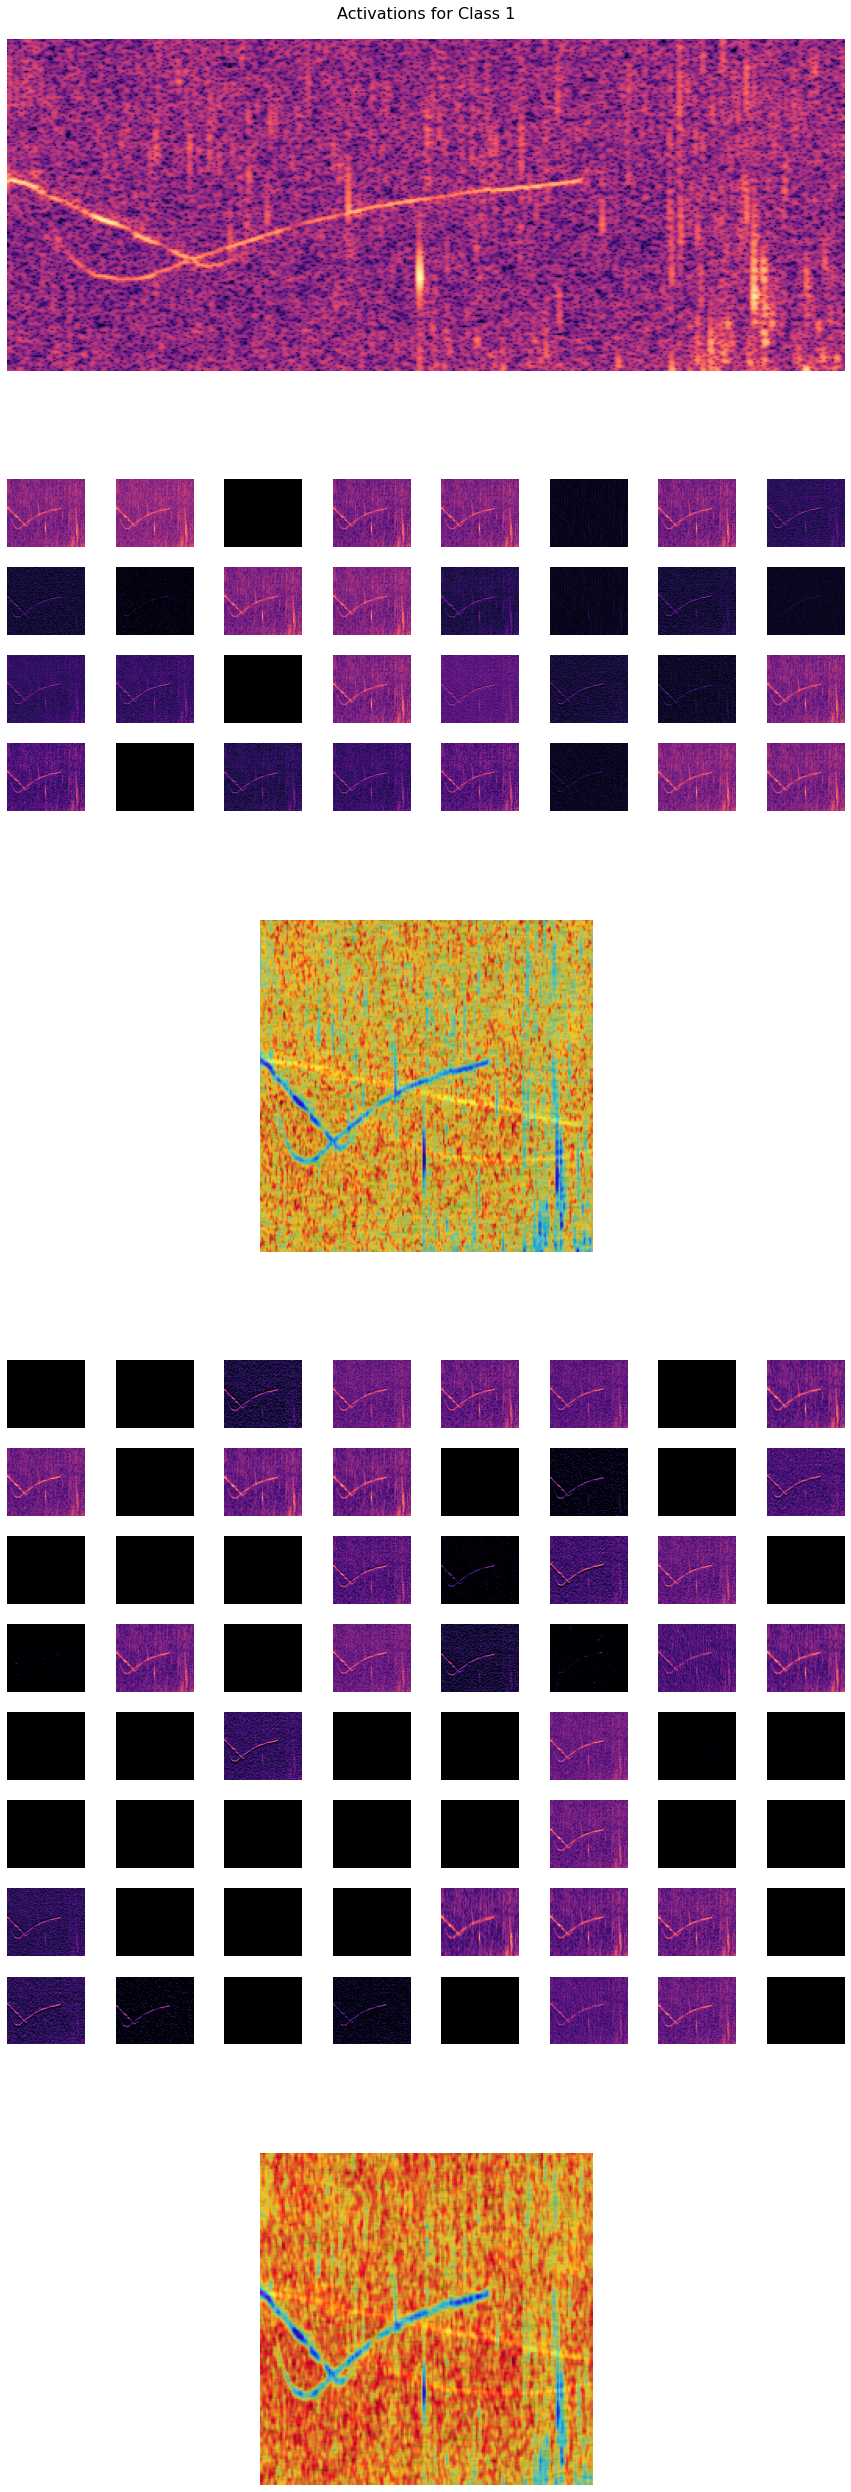

In [139]:
vis_activations(X_specs_D_train, Y_D_train, 50, trained_detector)